In [1]:
!nvidia-smi

Thu Feb 24 16:03:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install --quiet transformers==4.5.0
!pip install --quiet pytorch-lightning==1.2.7

     |████████████████████████████████| 2.1 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 34.0 MB/s 
     |████████████████████████████████| 895 kB 25.4 MB/s 
     |████████████████████████████████| 830 kB 5.4 MB/s 
     |████████████████████████████████| 134 kB 22.0 MB/s 
     |████████████████████████████████| 829 kB 33.2 MB/s 
     |████████████████████████████████| 397 kB 35.3 MB/s 
     |████████████████████████████████| 596 kB 34.8 MB/s 
     |████████████████████████████████| 1.1 MB 37.6 MB/s 
     |████████████████████████████████| 271 kB 47.5 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 144 kB 53.4 MB/s 


In [3]:
import json
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset,DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
from tqdm.auto import tqdm

In [4]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid',palette='muted',font_scale=1.2)
rcParams['figure.figsize']=16,10

In [5]:
pl.seed_everything(42)

Global seed set to 42


42

In [6]:
!gdown --id 1Hqg4iqm3Yz9Nzb3WsTffxnl2RqQAzEbD

Downloading...
From: https://drive.google.com/uc?id=1Hqg4iqm3Yz9Nzb3WsTffxnl2RqQAzEbD
To: /content/Musical_instruments_reviews.csv
100% 6.07M/6.07M [00:00<00:00, 24.4MB/s]


In [7]:
df=pd.read_csv("Musical_instruments_reviews.csv",encoding="latin-1")
df.head()

,reviewerID,asin,reviewerName,helpful,ctext,overall,text,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [8]:
df=df[["text","ctext"]]
df.head()

,text,ctext
0,good,"Not much to write about here, but it does exac..."
1,Jake,The product does exactly as it should and is q...
2,It Does The Job Well,The primary job of this device is to block the...
3,GOOD WINDSCREEN FOR THE MONEY,Nice windscreen protects my MXL mic and preven...
4,No more pops when I record my vocals.,This pop filter is great. It looks and perform...


In [9]:
df.columns=["summary" , "text"]
df = df.dropna()
df.head()

,summary,text
0,good,"Not much to write about here, but it does exac..."
1,Jake,The product does exactly as it should and is q...
2,It Does The Job Well,The primary job of this device is to block the...
3,GOOD WINDSCREEN FOR THE MONEY,Nice windscreen protects my MXL mic and preven...
4,No more pops when I record my vocals.,This pop filter is great. It looks and perform...


In [10]:
df.shape

(10254, 2)

In [11]:
train_df,test_df=train_test_split(df,test_size=0.1)
train_df.shape,test_df.shape

((9228, 2), (1026, 2))

In [12]:
from pandas.core.internals.managers import T
class NewsSummaryDataset(Dataset):
  def __init__(
      self,
      data:pd.DataFrame,
      tokenizer: T5Tokenizer,
      text_max_token_len : int =512,
      summary_max_token_len : int =128
  ):
    self.tokenizer=tokenizer
    self.data=data
    self.text_max_token_len= text_max_token_len
    self.summary_max_token_len=summary_max_token_len

  def __len__(self):
    return len(self.data)
  def __getitem__(self,index:int):
    data_row = self.data.iloc[index]
    text=data_row["text"]
    text_encoding=tokenizer(text,
        max_length=self.text_max_token_len,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    summary_encoding=tokenizer(
        data_row["summary"],
        max_length=self.summary_max_token_len,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    labels=summary_encoding["input_ids"]
    labels[labels==0]=-100
    return dict(
        text=text,
        summary= data_row["summary"],
        text_input_ids = text_encoding["input_ids"].flatten(),
        text_attention_mask=text_encoding["attention_mask"].flatten(),
        labels=labels.flatten(),
        labels_attention_mask = summary_encoding["attention_mask"].flatten()
    )



In [13]:
class NewsSummaryDataModule(pl.LightningDataModule):

  def __init__(
      self,
      train_df:pd.DataFrame,
      test_df:pd.DataFrame,
      tokenizer:T5Tokenizer,
      batch_size: int =4,
      text_max_token_len:int=512,
      summary_max_token_len:int=128
  ):
    super().__init__()
    self.train_df=train_df
    self.test_df=test_df
    self.tokenizer=tokenizer
    self.batch_size=batch_size
    self.text_max_token_len=text_max_token_len
    self.summary_max_token_len=summary_max_token_len

  def setup(self,stage=None):
    self.train_dataset=NewsSummaryDataset(
    self.train_df,
    self.tokenizer,
    self.text_max_token_len,
    self.summary_max_token_len
    )
    self.test_dataset=NewsSummaryDataset(
    self.test_df,
    self.tokenizer,
    self.text_max_token_len,
    self.summary_max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2
        
    )
  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2
        
    )



In [14]:
MODEL_NAME="t5-base"
tokenizer=T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [15]:
text_token_counts,summary_token_counts=[],[]
for _,row in train_df.iterrows():
  text_token_count=len(tokenizer.encode(row["text"]))
  text_token_counts.append(text_token_count)
  summary_token_count=len(tokenizer.encode(row["summary"]))
  summary_token_counts.append(summary_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'Summary text token counts')

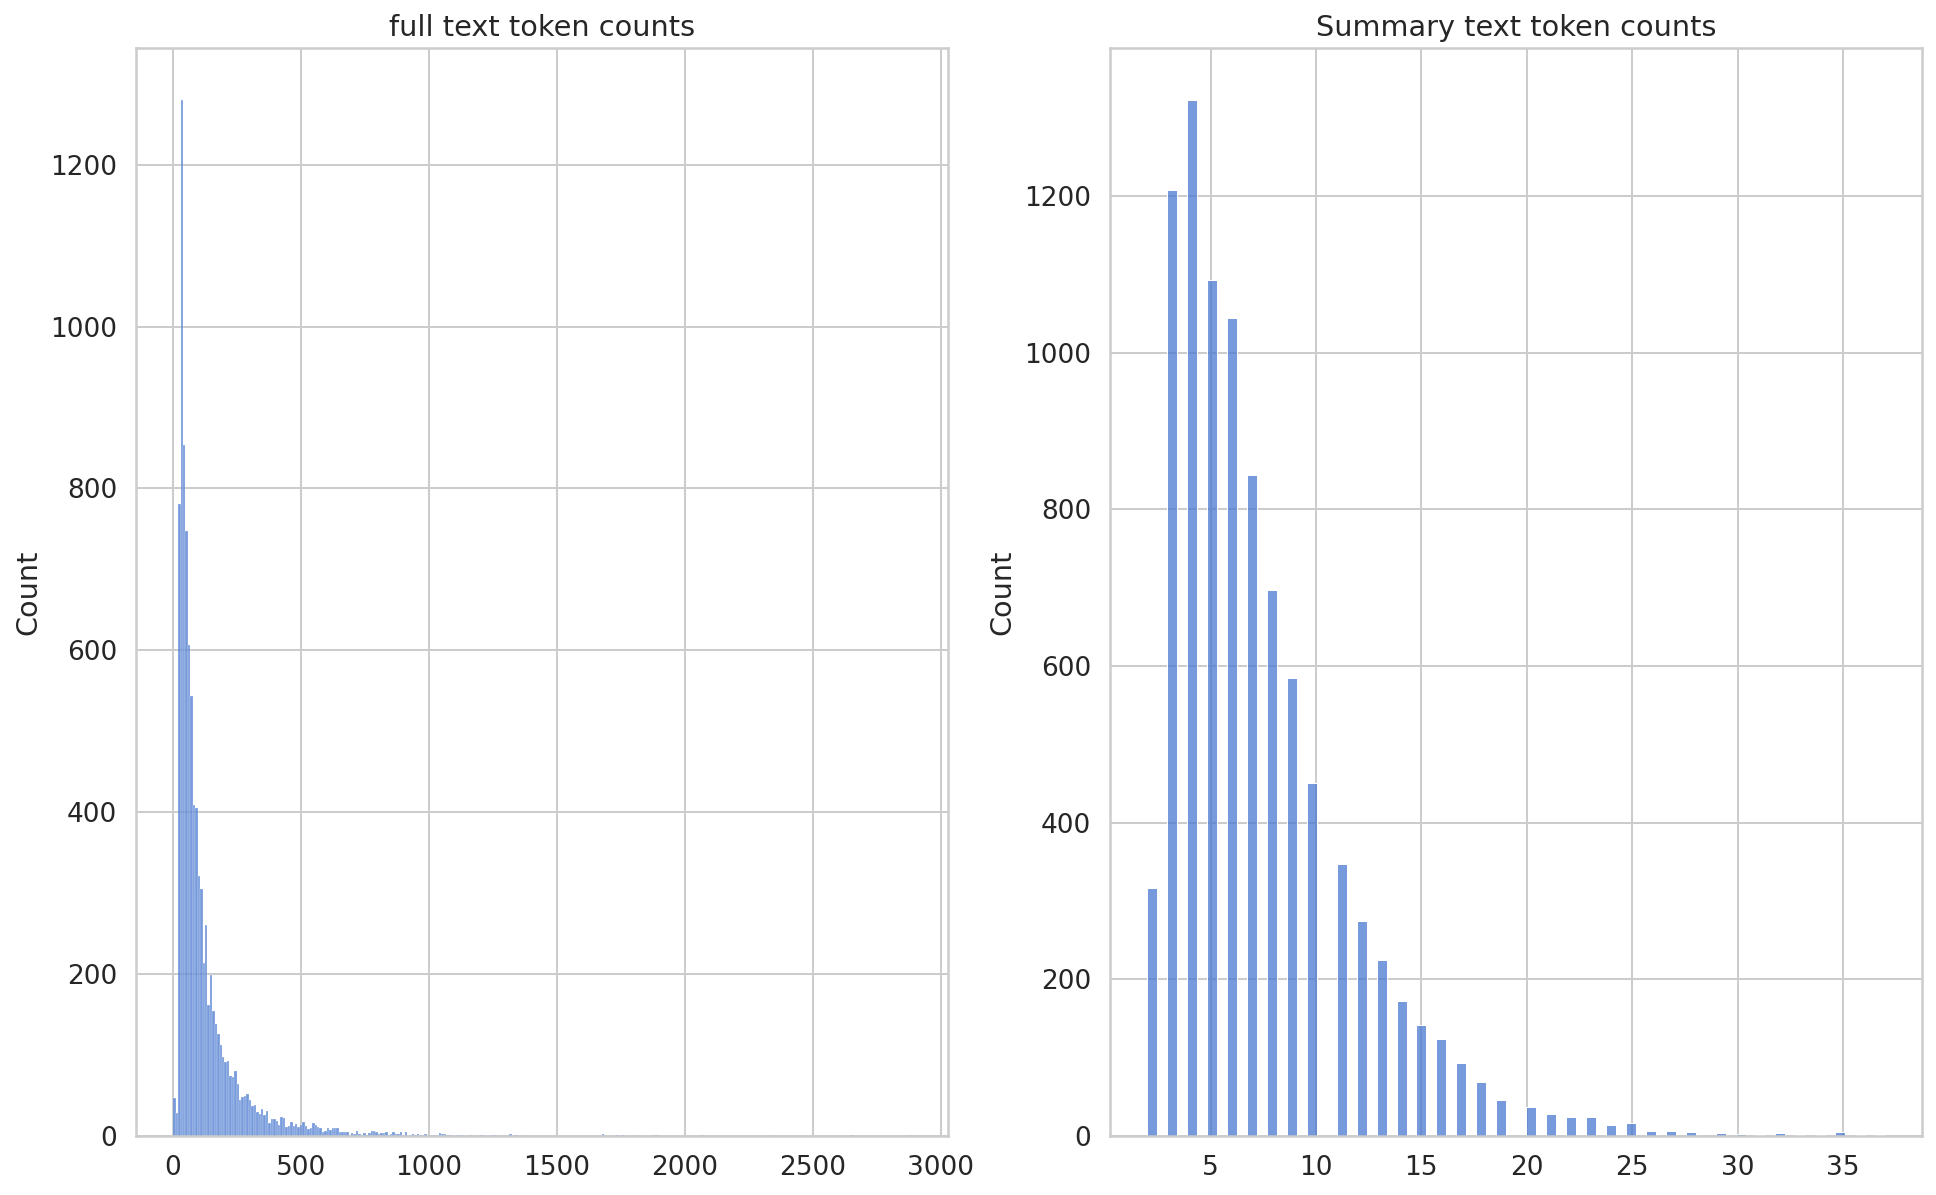

In [16]:
fig ,(ax1,ax2)=plt.subplots(1,2)
sns.histplot(text_token_counts,ax=ax1)
ax1.set_title("full text token counts")
sns.histplot(summary_token_counts,ax=ax2)
ax2.set_title("Summary text token counts")

In [17]:
N_EPOCHS=3
BATCH_SIZE=4
data_module=NewsSummaryDataModule(train_df,test_df,tokenizer,batch_size=BATCH_SIZE)

In [18]:
class NewsSummaryModel(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.model=T5ForConditionalGeneration.from_pretrained(MODEL_NAME,return_dict=True)
  def forward(self,input_ids,attention_mask,decoder_attention_mask,labels=None):

    output=self.model(
        input_ids,
        attention_mask=attention_mask,
        labels=labels,
        decoder_attention_mask=decoder_attention_mask
    )
    return output.loss,output.logits

  def training_step(self,batch,batch_idx):
    input_ids=batch["text_input_ids"]
    attention_mask=batch["text_attention_mask"]
    labels=batch["labels"]
    labels_attention_mask=batch["labels_attention_mask"]
    loss,outputs= self(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_attention_mask=labels_attention_mask,
        labels=labels
    )
    self.log("train_loss",loss,prog_bar=True,logger=True)
    return loss

  def test_step(self,batch,batch_idx):
      input_ids=batch["text_input_ids"]
      attention_mask=batch["text_attention_mask"]
      labels=batch["labels"]
      labels_attention_mask=batch["labels_attention_mask"]
      loss,outputs= self(
          input_ids=input_ids,
          attention_mask=attention_mask,
          decoder_attention_mask=labels_attention_mask,
          labels=labels
      )
      self.log("test_loss",loss,prog_bar=True,logger=True)
      return loss

  def configure_optimizers(self):
      return AdamW(self.parameters(),lr=0.0001)

In [19]:
model=NewsSummaryModel()

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [20]:
%reload_ext tensorboard
%tensorboard --logdir ./lightning_logs

<IPython.core.display.Javascript object>

In [21]:
checkpoint_callback=ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="train_loss",
    mode="min"
)
logger=TensorBoardLogger("lightening_logs",name="news-summary")
trainer=pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30,
    
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [22]:
trainer.fit(model,data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 2306: train_loss reached 3.43283 (best 3.43283), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
Epoch 1, global step 4613: train_loss reached 3.21805 (best 3.21805), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
Epoch 2, step 6920: train_loss was not in top 1


1

In [30]:
trained_model=NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)
trained_model.freeze()
def summarize(text):
  text_encoding=tokenizer(
      text,
      max_length=512,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      add_special_tokens=True,
      return_tensors="pt"
  )

  generated_ids=trained_model.model.generate(
      input_ids=text_encoding["input_ids"],
      attention_mask=text_encoding["attention_mask"],
      max_length=150,
      num_beams=2,
      repetition_penalty=2.5,
      length_penalty=1.0,
      early_stopping=True
  )

  preds=[
         tokenizer.decode(gen_id,skip_special_tokens=True,clean_up_tokenization_spaces=True)
         for gen_id in generated_ids
  ]

  return "".join(preds)

In [31]:
sample_row=test_df.iloc[1]
text=sample_row["text"]
model_summary=summarize(text)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [27]:
text

'I don\'t know if 39" (from the top of the headstock to the bottom of the body {I know guitars are based on the size of the frets but no idea how to do that} ) is the normal size for an adult...However for $50 (its on sale at the time) even if its not I can still learn to play since thats why I bought it is to learn...The pick guard had some sort of plastic cover that was rough but doesn\'t really affect anything, since it seems like something was put on it to help shipping once removed the pick guard is fine.All togther whether its a full size adult or just one for kids its still pretty good.I am happy with it.Good clean sound, at least with my headphone amp (only amp I have).Comes with Whammy bar(thats what I know it as), one volume, two tone, the pickup sector switch, the cord that connects your guitar to your amp.**EDIT**So now that Amazon has grouped the guitar with many others (mostly the color differences) and that I have a little bit more knowlage of the guitar, not saying much

In [28]:
sample_row["summary"]

'39 inch guitar...'

In [32]:
model_summary

'Good guitar for the price'